In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ..

/


In [ ]:
cd content/drive/MyDrive/MedIx\ REU/Datasets

/content/drive/MyDrive/MedIx REU/Datasets


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
import numpy as np  # linear alg
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, MinMaxScaler
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering
import os
from os import path
#from s_dbw import S_Dbw, SD

In [ ]:
from sklearn.preprocessing import StandardScaler

class KMeans:
    def __init__(self, n_clusters=8, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X_train):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([self.euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = self.euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = self.euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs

    def euclidean(self, point, data):
        """
        Euclidean distance between point & data.
        Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
        """
        return np.sqrt(np.sum((point - data)**2, axis=1))

In [ ]:
##### Import Trained Model #####
model = keras.models.load_model("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Autoencoder/spic_files/enc_VAE_my_model_299_Spic" , compile = True)

In [ ]:
model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 72, 72, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 72, 72, 32)   320         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 72, 72, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 72, 72, 32)   0           ['bn_1[0][0]']                   
                                                                                            

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="flatten").output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 72, 72, 1)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 72, 72, 32)        320       
                                                                 
 bn_1 (BatchNormalization)   (None, 72, 72, 32)        128       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 72, 72, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 36, 36, 64)        18496     
                                                                 
 bn_2 (BatchNormalization)   (None, 36, 36, 64)        256       
                                                                 
 lrelu_2 (LeakyReLU)         (None, 36, 36, 64)        0     

In [ ]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [ ]:
def getSamePadding(this_array):
    # Array to be added as row
    row_to_be_added = this_array[70]
    # Adding row to numpy array
    result = np.vstack ((this_array, row_to_be_added) )

    # Array to be added as column
    column = this_array[:, 70]
    last_item = this_array[70, 70]

    # Adding column to numpy array
    column_to_be_added = np.append(column, last_item)

    # stack column to numpy array
    new_img = np.column_stack((result, column_to_be_added))
    return new_img

In [ ]:
total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Spiculation/Agreement_Binary_Rating.csv")
total_nod = total['noduleID']
total_nod = np.array(total_nod)

image_folder = '/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332'
train_images = []
train_noduleId = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                train_noduleId.append(noduleID)
                temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                temp_image = getNormed(temp_image)
                enlarged_img = getSamePadding(temp_image)
                train_images.append(enlarged_img)

/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332
Malignancy_5
Malignancy_1
Malignancy_4
Malignancy_2
Malignancy_3


In [ ]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

      noduleID
0          324
1         1888
2         1606
3         1427
4         1760
...        ...
1327      2301
1328      2583
1329      1772
1330       231
1331      2540

[1332 rows x 1 columns]


In [ ]:
train_slices = pd.merge(tr_df, total)
display(train_slices)

,noduleID,InstanceID,noduleID.1,Binary Rating,Agreement_name,Agreement,old Binary Rating,old_Binary_Rating_name,old_Agreement,old_Agreement_name,old_Two_Agreement,old_Two_Agreement_name
0,324,4732,324,2,Low Radiologiests Agreement,1,0,Not Spiculated,2,High Radiologist Agreement,1,Full_High
1,1888,28743,1888,2,Low Radiologiests Agreement,1,2,Unknown,1,Low Radiologist Agreement,0,Low_No
2,1606,24119,1606,2,Low Radiologiests Agreement,1,0,Not Spiculated,3,All Radiologist Agreement,1,Full_High
3,1427,21366,1427,1,High Radiologiests Agreement,2,0,Not Spiculated,3,All Radiologist Agreement,1,Full_High
4,1760,26447,1760,1,Full Radiologiests Agreement,3,2,Unknown,1,Low Radiologist Agreement,0,Low_No
...,...,...,...,...,...,...,...,...,...,...,...,...
1327,2301,35200,2301,0,High Radiologiests Agreement,2,2,Unknown,0,No Radiologist Agreement,0,Low_No
1328,2583,39596,2583,0,High Radiologiests Agreement,2,2,Unknown,1,Low Radiologist Agreement,0,Low_No
1329,1772,26626,1772,2,Low Radiologiests Agreement,1,2,Unknown,1,Low Radiologist Agreement,0,Low_No
1330,231,3308,231,1,High Radiologiests Agreement,2,0,Not Spiculated,2,High Radiologist Agreement,1,Full_High


In [ ]:
train_ids = train_slices["Binary Rating"]

In [ ]:
##### Run all data (testing, training, and validation) to retrieve embeddings and plot tsne #####                               USE THIS ONE! :)

total_data = np.array(train_images).reshape(-1,72,72,1)
#print(total_data.shape)

total_embeddings_before = feature_extractor.predict(total_data)
total_embeddings2 = (total_embeddings_before - total_embeddings_before.min()) / (total_embeddings_before.max() - total_embeddings_before.min())
tot_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings2)

42/42 [==============================] - 9s 6ms/step


In [ ]:
np.any(np.isnan(total_embeddings2))

False

In [ ]:
# Fit centroids to dataset
centers = 1
kmeans = KMeans(n_clusters=centers)
kmeans.fit(total_embeddings2)
#centroid = kmeans.evaluate(df_feature)
centroid = kmeans.centroids

In [ ]:
dist = kmeans.euclidean(centroid, total_embeddings2)

In [ ]:
df_distance = pd.DataFrame()
df_distance['InstanceID'] = train_slices['InstanceID']
df_distance['Agreement'] = train_slices['Agreement_name']
df_distance['Distance'] = dist
df_distance['Spiculation'] = train_ids
display(df_distance)

,InstanceID,Agreement,Distance,Spiculation
0,4732,Low Radiologiests Agreement,5.436087,2
1,28743,Low Radiologiests Agreement,7.274587,2
2,24119,Low Radiologiests Agreement,5.584279,2
3,21366,High Radiologiests Agreement,5.419829,1
4,26447,Full Radiologiests Agreement,6.915697,1
...,...,...,...,...
1327,35200,High Radiologiests Agreement,5.246740,0
1328,39596,High Radiologiests Agreement,7.453985,0
1329,26626,Low Radiologiests Agreement,5.947716,2
1330,3308,High Radiologiests Agreement,5.300139,1


In [ ]:
df_distance.to_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Autoencoder/spic_files/AE_spic_var_distance.csv")

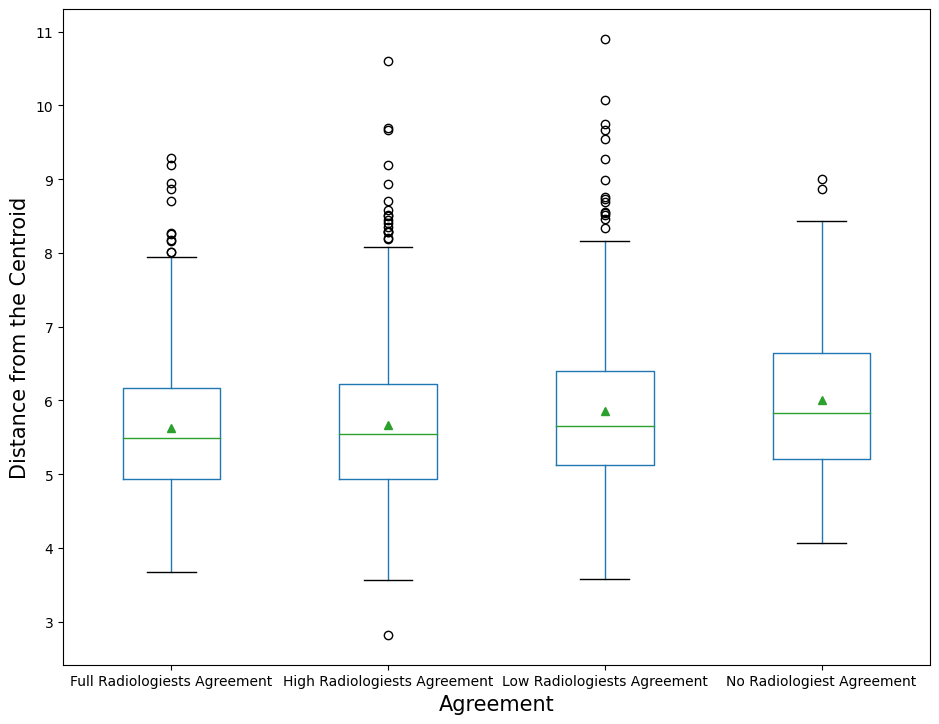

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df_distance.boxplot(by='Agreement',column =['Distance'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
#plt.ylim([0.0, 1.0])
plt.ylabel("Distance from the Centroid", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
#plt.xticks([0,1, 2, 3],['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree'])
plt.show()

In [ ]:
m1 = df_distance.groupby(['Agreement'])['Distance'].mean().values
print(m1)

[5.6327147 5.6639166 5.850407  6.007773 ]


In [ ]:
m2 = df_distance.groupby(['Agreement'])['Distance'].median().values
print(m2)

[5.496044  5.5456142 5.6529064 5.8337455]


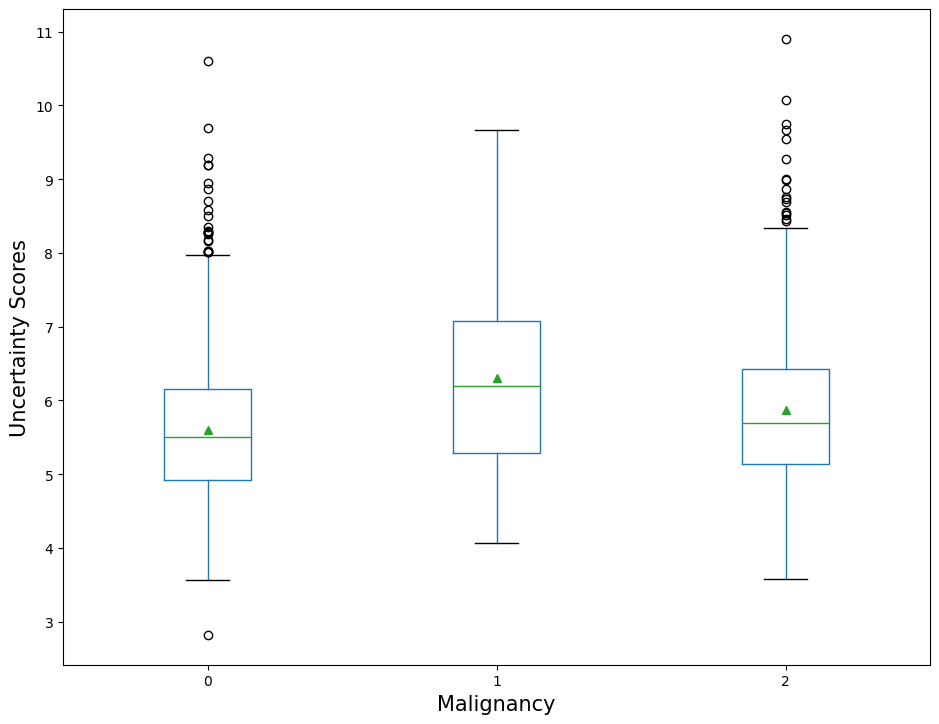

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df_distance.boxplot(by='Spiculation',column =['Distance'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')

plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Malignancy", fontdict={'fontsize':15})
#plt.xticks([1, 2, 3,4], ['Not Malignant','Malignant', 'Indeterminate','Evaluation on low/No Agreement'])
plt.show()

In [ ]:
m1 = df_distance.groupby(['Spiculation'])['Distance'].mean().values
print(m1)
m2 = df_distance.groupby(['Spiculation'])['Distance'].median().values
print(m2)

[5.6043506 6.3019543 5.871996 ]
[5.5036273 6.196561  5.688896 ]
